# CDM 4th Homework
Fatemeh Shiri

سوال تشریحی اول

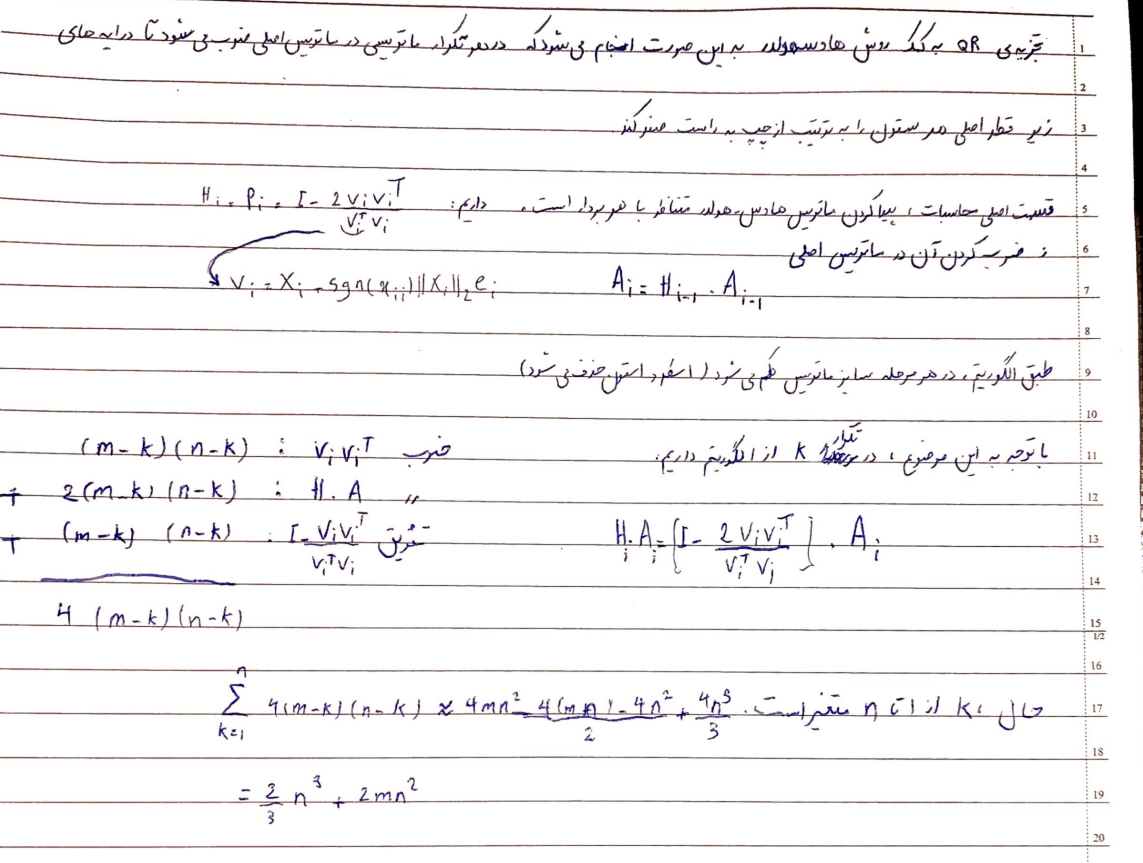

## Import Libraries

In [1]:

import numpy as np
import os
import cv2
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
import pandas as pd


## Read Training Data

In [2]:
def load_local_data(data_path):
    images = {}

    for label in range(10):
        images[label] = []

        folder_path = os.path.join(data_path, str(label))
        file_names = os.listdir(folder_path)

        for file_name in file_names:
            image_path = os.path.join(folder_path, file_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            if image is not None:
                images[label].append(image.flatten())

    return images


In [3]:
data_path = 'TinyMNIST/train/'
images = load_local_data(data_path)

for label, image in images.items():
    print(f"Number {label}: {len(image)} images")

Number 0: 400 images
Number 1: 400 images
Number 2: 400 images
Number 3: 400 images
Number 4: 400 images
Number 5: 400 images
Number 6: 400 images
Number 7: 400 images
Number 8: 400 images
Number 9: 400 images


In [4]:
A = {}
for i in range(10):
    A[i] = np.empty((0, 784))
    for j in images[i]:
        A[i] = np.vstack((A[i], j))

## Customized Version

### QR Decomposition by House-Holder

In [ ]:
def qr_decomposition(A):
    m, n = A.shape
    Q = np.zeros((m, n))
    R = np.zeros((n, n))

    for j in range(n):
        v = A[:, j]

        for i in range(j):
            R[i, j] = np.dot(Q[:, i], A[:, j])
            v -= R[i, j] * Q[:, i]

        R[j, j] = np.linalg.norm(v)
        Q[:, j] = v / R[j, j]

    return Q, R

### Least Squares

In [152]:
def solve_linear_system(A, b):
    Q, R = qr_decomposition(A)
    Qb = np.dot(Q.T, b)
    n = R.shape[1]
    x = np.zeros(n)

    for i in range(n - 1, -1, -1):
        x[i] = (Qb[i] - np.dot(R[i, i+1:], x[i+1:])) / R[i, i]

    return x

### Predict

In [162]:
def predict(image_path, A):
    image = cv2.imread(f'{image_path}', cv2.IMREAD_GRAYSCALE).flatten()
    solutions = []
    for a in A.keys():
        solution = solve_linear_system(A[a].T, image.reshape(-1,1))
        solutions.append(solution)
    X = [A[0].T, A[1].T, A[2].T, A[3].T, A[4].T, A[5].T, A[6].T, A[7].T, A[8].T, A[9].T]
    residuals = [np.linalg.norm(image - np.dot(X, x)) for X, x in zip(X, solutions)]
    return np.argmin(residuals)


In [155]:
df = pd.DataFrame(columns=['id', 'label'])

for label in range(10):
    img_list = os.listdir(f"TinyMNIST/test_2/{label}")
    for img in img_list:
        data = {
        "id": int(img.split(".")[0].split('_')[1]),
        "label": int(label)
        }

        # df.append(pd.DataFrame(data))
        df.loc[len(df)] = data

test = df.drop_duplicates().sort_values('id')

In [164]:
df = pd.DataFrame(columns=['id', 'label'])


for img in os.listdir('TinyMNIST/test'):
    data = {
        "id": int(img.split(".")[0].split('_')[1]),
        "label": int(predict(f'TinyMNIST/test/{img}', A))
    }
    df.loc[len(df)] = data

pred = df.drop_duplicates().sort_values('id')

In [165]:
pred.to_csv('pred.csv')

In [166]:
accuracy_score(test['label'], pred['label'])

0.8166666666666667

In [167]:
confusion_matrix(test['label'], pred['label'])

array([[56,  0,  1,  0,  0,  1,  2,  0,  1,  0],
       [ 0, 56,  1,  0,  0,  0,  0,  0,  2,  0],
       [ 0,  1, 50,  2,  1,  0,  1,  0,  3,  0],
       [ 0,  1,  2, 47,  0,  1,  1,  1,  6,  1],
       [ 0,  0,  1,  1, 44,  0,  1,  1,  4,  8],
       [ 2,  0,  1,  4,  0, 36,  5,  0, 11,  0],
       [ 0,  1,  2,  0,  0,  1, 57,  0,  0,  0],
       [ 0,  1,  0,  0,  2,  0,  1, 42,  1, 15],
       [ 0,  6,  0,  3,  0,  1,  2,  0, 46,  2],
       [ 1,  0,  0,  0,  2,  0,  0,  0,  1, 56]], dtype=int64)

In [168]:
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

roc_auc_score_multiclass(test['label'], pred['label'])

{0: 0.9562334620882631,
 1: 0.9653341270089915,
 2: 0.9236544089578826,
 3: 0.8824074074074074,
 4: 0.862037037037037,
 5: 0.8013878880917322,
 6: 0.955153745551872,
 7: 0.8368509413598753,
 8: 0.8564814814814814,
 9: 0.9425925925925925}

## Numpy Version

In [176]:
def qr_decomposition(A):
    m, n = A.shape
    Q, R = np.linalg.qr(A)
    return Q, R

def solve_linear_system(A, b):
    Q, R = qr_decomposition(A)
    Qb = np.dot(Q.T, b)
    x = np.linalg.solve(R, Qb)
    return x

def predict_np(image_path, A):
    image = cv2.imread(f'{image_path}', cv2.IMREAD_GRAYSCALE).flatten()
    solutions = []
    for a in A.keys():
        solution = solve_linear_system(A[a].T, image)
        solutions.append(solution)
    X = [A[0].T, A[1].T, A[2].T, A[3].T, A[4].T, A[5].T, A[6].T, A[7].T, A[8].T, A[9].T]
    residuals = [np.linalg.norm(image - np.dot(X, x)) for X, x in zip(X, solutions)]
    return np.argmin(residuals)

In [177]:
df_np = pd.DataFrame(columns=['id', 'label'])


for img in os.listdir('TinyMNIST/test'):
    data = {
        "id": int(img.split(".")[0].split('_')[1]),
        "label": int(predict_np(f'TinyMNIST/test/{img}', A))
    }
    df_np.loc[len(df_np)] = data

pred_np = df_np.drop_duplicates().sort_values('id')

In [178]:
accuracy_score(test['label'], pred_np['label'])

0.8166666666666667

In [180]:
confusion_matrix(test['label'], pred_np['label'])

array([[56,  0,  1,  0,  0,  1,  2,  0,  1,  0],
       [ 0, 56,  1,  0,  0,  0,  0,  0,  2,  0],
       [ 0,  1, 50,  2,  1,  0,  1,  0,  3,  0],
       [ 0,  1,  2, 47,  0,  1,  1,  1,  6,  1],
       [ 0,  0,  1,  1, 44,  0,  1,  1,  4,  8],
       [ 2,  0,  1,  4,  0, 36,  5,  0, 11,  0],
       [ 0,  1,  2,  0,  0,  1, 57,  0,  0,  0],
       [ 0,  1,  0,  0,  2,  0,  1, 42,  1, 15],
       [ 0,  6,  0,  3,  0,  1,  2,  0, 46,  2],
       [ 1,  0,  0,  0,  2,  0,  0,  0,  1, 56]], dtype=int64)

In [181]:
roc_auc_score_multiclass(actual_class=test['label'], pred_np['label'])

{0: 0.9562334620882631,
 1: 0.9653341270089915,
 2: 0.9236544089578826,
 3: 0.8824074074074074,
 4: 0.862037037037037,
 5: 0.8013878880917322,
 6: 0.955153745551872,
 7: 0.8368509413598753,
 8: 0.8564814814814814,
 9: 0.9425925925925925}

## Training Data Sampling

### 200

In [199]:
B = {}
for i in range(10):
    selected_cols = np.random.choice(A[i].shape[0], size=200, replace=False)
    B[i] = A[i][selected_cols,:]

In [204]:
df_200 = pd.DataFrame(columns=['id', 'label'])


for img in os.listdir('TinyMNIST/test'):
    data = {
        "id": int(img.split(".")[0].split('_')[1]),
        "label": int(predict_np(f'TinyMNIST/test/{img}', B))
    }
    df_200.loc[len(df_200)] = data

pred_200 = df_200.drop_duplicates().sort_values('id')

In [205]:
accuracy_score(test['label'], pred_200['label'])

0.25166666666666665

In [206]:
confusion_matrix(test['label'], y_pred=pred_200['label'])

array([[ 2,  0, 12,  1,  5, 33,  2,  4,  0,  2],
       [ 0,  2,  0,  0,  5,  4,  0, 42,  2,  4],
       [ 1,  0, 26,  0,  2, 27,  0,  2,  0,  0],
       [ 0,  0,  5,  2,  4, 47,  1,  1,  0,  0],
       [ 0,  0,  2,  0, 39,  9,  1,  7,  0,  2],
       [ 0,  0,  0,  0,  2, 35,  0, 21,  0,  1],
       [ 0,  0,  8,  1,  6, 33, 11,  2,  0,  0],
       [ 0,  0,  4,  0, 18,  7,  0, 33,  0,  0],
       [ 0,  0,  1,  0,  1, 46,  2,  9,  1,  0],
       [ 0,  0,  0,  0, 22, 14,  0, 23,  1,  0]], dtype=int64)

In [207]:
roc_auc_score_multiclass(actual_class=test['label'], pred_class=pred_200['label'])

{0: 0.5154657988381641,
 1: 0.5169491525423728,
 2: 0.6946176358315307,
 3: 0.5148148148148148,
 4: 0.7648148148148148,
 5: 0.5932829975876437,
 6: 0.5845980717175097,
 7: 0.6629691809569492,
 8: 0.5055555555555555,
 9: 0.49166666666666664}

### 300

In [209]:
C = {}
for i in range(10):
    selected_cols = np.random.choice(A[i].shape[0], size=300, replace=False)
    C[i] = A[i][selected_cols,:]

In [214]:
df_300 = pd.DataFrame(columns=['id', 'label'])


for img in os.listdir('TinyMNIST/test'):
    data = {
        "id": int(img.split(".")[0].split('_')[1]),
        "label": int(predict_np(f'TinyMNIST/test/{img}', C))
    }
    df_300.loc[len(df_300)] = data

pred_300 = df_300.drop_duplicates().sort_values('id')

In [215]:
accuracy_score(test['label'], pred_300['label'])

0.39666666666666667

In [216]:
confusion_matrix(test['label'], y_pred=pred_300['label'])

array([[ 7,  0,  0,  0, 11,  0,  8, 11, 17,  7],
       [ 0, 53,  0,  0,  3,  0,  0,  0,  3,  0],
       [ 2,  9,  0,  2,  5,  0,  3,  8, 29,  0],
       [ 0,  1,  0,  2,  4,  0,  0,  5, 46,  2],
       [ 0,  1,  0,  1, 35,  0,  0,  6,  4, 13],
       [ 0,  2,  0,  0,  5,  3,  3,  1, 45,  0],
       [ 0,  1,  0,  0, 15,  1, 33,  0, 11,  0],
       [ 0,  0,  0,  0, 20,  0,  0, 31,  1, 10],
       [ 0,  1,  0,  0,  2,  0,  1,  2, 52,  2],
       [ 0,  0,  0,  0, 29,  0,  0,  6,  3, 22]], dtype=int64)

In [217]:
roc_auc_score_multiclass(actual_class=test['label'], pred_class=pred_300['label'])

{0: 0.5555217616107545,
 1: 0.9352893261067076,
 2: 0.5,
 3: 0.513888888888889,
 4: 0.7046296296296297,
 5: 0.5244995143958144,
 6: 0.7565771465068888,
 7: 0.7137546468401487,
 8: 0.7861111111111111,
 9: 0.6518518518518519}

### 50

In [218]:
D = {}
for i in range(10):
    selected_cols = np.random.choice(A[i].shape[0], size=50, replace=False)
    D[i] = A[i][selected_cols,:]

In [219]:
df_50 = pd.DataFrame(columns=['id', 'label'])


for img in os.listdir('TinyMNIST/test'):
    data = {
        "id": int(img.split(".")[0].split('_')[1]),
        "label": int(predict_np(f'TinyMNIST/test/{img}', D))
    }
    df_50.loc[len(df_50)] = data

pred_50 = df_50.drop_duplicates().sort_values('id')

In [222]:
accuracy_score(test['label'], pred_50['label'])

0.225

In [223]:
confusion_matrix(test['label'], y_pred=pred_50['label'])

array([[ 0,  0,  0,  8, 10, 12,  0, 31,  0,  0],
       [ 0,  0,  0, 44,  1,  0,  8,  5,  1,  0],
       [ 0,  0,  0, 35,  0,  0,  0, 23,  0,  0],
       [ 0,  0,  0, 48,  3,  0,  0,  8,  1,  0],
       [ 0,  0,  0, 16, 32,  1,  0, 11,  0,  0],
       [ 0,  0,  0, 19,  6, 16,  0, 17,  1,  0],
       [ 0,  0,  0, 31, 10,  1,  0, 19,  0,  0],
       [ 0,  0,  0, 11, 13,  0,  0, 38,  0,  0],
       [ 0,  0,  0, 37,  2,  0,  0, 20,  1,  0],
       [ 0,  0,  0, 13, 25,  0,  0, 22,  0,  0]], dtype=int64)

In [224]:
roc_auc_score_multiclass(actual_class=test['label'], pred_class=pred_50['label'])

{0: 0.5,
 1: 0.5,
 2: 0.5,
 3: 0.7018518518518518,
 4: 0.7018518518518517,
 5: 0.6226542184905541,
 6: 0.49257884972170685,
 7: 0.6614702002638205,
 8: 0.5055555555555555,
 9: 0.5}